# Example for the Beijing Air Quality 2.5 Dataset

https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [ ]:
!pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 1.2 MB/s eta 0:00:00


In [ ]:
import dill

import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from IPython.display import clear_output

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Dataset Download and Preprocess

In [ ]:
dataset_link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'
df = pd.read_csv(dataset_link)

In [ ]:
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [ ]:
df.isnull().sum()

No          0
year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64

In [ ]:
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []

        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1

        clear_output(wait=True)
        plt.plot(self.x, self.losses, label='loss')
        plt.plot(self.x, self.val_losses, label='val_loss')
        plt.legend()
        plt.show();

plot_losses = PlotLosses()

Data Preprocessing

In [ ]:
dataset_link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'
df = pd.read_csv(dataset_link)

print(len(df), len(df.dropna()))

df_temp = df.copy()
df_temp = df_temp.dropna()
df_temp = df_temp.reset_index()


df_temp = df_temp.drop(['index', 'No', 'day', 'month', 'year', 'hour'], axis=1)
df_temp['cbwd'] = df_temp['cbwd'].astype('category').cat.codes

epochs = 150

normalize = True
standardize = False

min_max_dict = {}
std_mean_dict = {}

if normalize:

    for feature_name in df_temp.columns:
        max_value = df_temp[feature_name].max()
        min_value = df_temp[feature_name].min()

        df_temp[feature_name] = (df_temp[feature_name] - min_value) / (max_value - min_value)

        min_max_dict[feature_name] = {'max': max_value, 'min': min_value}

elif standardize:

    for feature_name in df_temp.columns:
        std_value = df_temp[feature_name].std()
        mean_value = df_temp[feature_name].mean()

        df_temp[feature_name] = (df_temp[feature_name] - mean_value) / std_value

        std_mean_dict[feature_name] = {'std': std_value, 'mean': mean_value}

43824 41757


In [ ]:
df_temp.iloc[:10]

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,0.129779,0.352941,0.245902,0.527273,0.666667,0.002372,0.000000,0.0
1,0.148893,0.367647,0.245902,0.527273,0.666667,0.003947,0.000000,0.0
2,0.159960,0.426471,0.229508,0.545455,0.666667,0.005522,0.000000,0.0
3,0.182093,0.485294,0.229508,0.563636,0.666667,0.008690,0.037037,0.0
4,0.138833,0.485294,0.229508,0.563636,0.666667,0.010265,0.074074,0.0
5,0.109658,0.485294,0.213115,0.563636,0.666667,0.011840,0.111111,0.0
6,0.105634,0.485294,0.213115,0.581818,0.666667,0.015008,0.148148,0.0
7,0.124748,0.485294,0.229508,0.600000,0.666667,0.018176,0.000000,0.0
8,0.120724,0.470588,0.213115,0.600000,0.666667,0.021344,0.000000,0.0
9,0.132797,0.485294,0.229508,0.618182,0.666667,0.024512,0.000000,0.0


In [ ]:
X_temp = df_temp.drop(['pm2.5'], axis=1)
y_temp = df_temp['pm2.5']

In [ ]:
def create_sequences(X, y, n_steps=24):
    dataset_X = []
    dataset_y = []

    for i in range(len(X) - (n_steps + 2)):
        dataset_X.append(X.iloc[i:i + n_steps].values)
        dataset_y.append(y.iloc[i + n_steps + 1])

    return np.asarray(dataset_X), np.asarray(dataset_y)

In [ ]:
dataset_temp = create_sequences(X_temp, y_temp)

In [ ]:
dataset_temp[0].shape

(41731, 24, 7)

In [ ]:
dataset_temp[1].shape

(41731,)

# Training CNN models

In [ ]:
X = dataset_temp[0]
y = dataset_temp[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [ ]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv1D(32, 3, activation='relu', input_shape=(24, 7)))
cnn_model.add(layers.MaxPooling1D(2))
cnn_model.add(layers.Conv1D(64, 3, activation='relu'))
cnn_model.add(layers.MaxPooling1D(2))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(100, activation='relu'))
cnn_model.add(layers.Dropout(0.3))
cnn_model.add(layers.Dense(50, activation='relu'))
cnn_model.add(layers.Dropout(0.3))
cnn_model.add(layers.Dense(1))

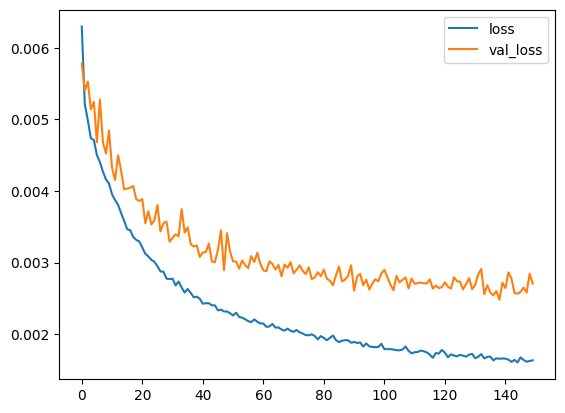

In [ ]:
cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

history = cnn_model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=0, callbacks=[plot_losses])

In [ ]:
dnn_model = models.Sequential()
dnn_model.add(layers.Flatten())
dnn_model.add(layers.Dense(500, activation='relu'))
dnn_model.add(layers.Dropout(0.3))
dnn_model.add(layers.Dense(250, activation='relu'))
dnn_model.add(layers.Dropout(0.3))
dnn_model.add(layers.Dense(100, activation='relu'))
dnn_model.add(layers.Dropout(0.3))
dnn_model.add(layers.Dense(1))

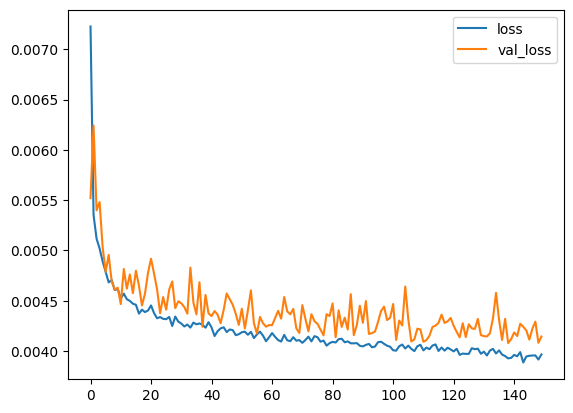

In [ ]:
dnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

history = dnn_model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=0, callbacks=[plot_losses])

# RNN models

In [ ]:
rnn_model = models.Sequential()
rnn_model.add(layers.LSTM(32, return_sequences=True))
rnn_model.add(layers.Flatten())
rnn_model.add(layers.Dense(100, activation='relu'))
rnn_model.add(layers.Dropout(0.3))
rnn_model.add(layers.Dense(1))

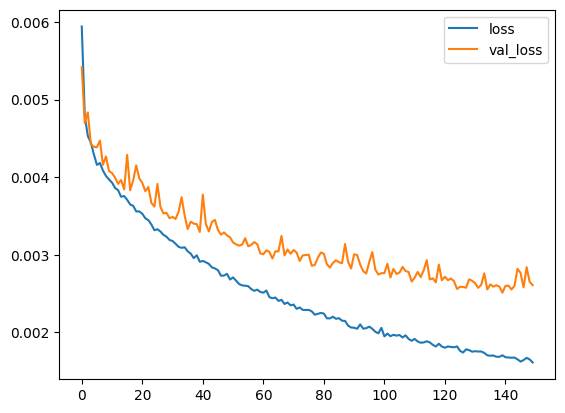

In [ ]:
rnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

history = rnn_model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=0, callbacks=[plot_losses])

In [ ]:
dataset_test = [X_test, y_test]
dataset_test_reduced = [X_test[:10000], y_test[:10000]]

cnn_model.save('/content/drive/MyDrive/MachineLearning/final_codes/Beijing_Air_Quality_models/beijing_air_2_5_cnn_model.h5')  # weights
dnn_model.save('/content/drive/MyDrive/MachineLearning/final_codes/Beijing_Air_Quality_models/beijing_air_2_5_dnn_model.h5')
rnn_model.save('/content/drive/MyDrive/MachineLearning/final_codes/Beijing_Air_Quality_models/beijing_air_2_5_rnn_model.h5')

with open('/content/drive/MyDrive/MachineLearning/final_codes/Beijing_Air_Quality_models/beijing_air_2_5_test_data.dill', 'wb') as f:
    dill.dump(dataset_test, f)

with open('/content/drive/MyDrive/MachineLearning/final_codes/Beijing_Air_Quality_models/beijing_air_2_5_test_data_reduced.dill', 'wb') as f:
    dill.dump(dataset_test_reduced, f)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import dill

import pandas as pd
import numpy as np

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

import tensorflow as tf

from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from IPython.display import clear_output

In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00501/PRSA2017_Data_20130301-20170228.zip'

resp = urlopen(url)


zipfile = ZipFile(BytesIO(resp.read()))
file_list = zipfile.namelist()

df_list = []

for file in file_list:
    if 'csv' in file:
        df = pd.read_csv(zipfile.open(file))
        df_list.append(df)

In [ ]:
pd.concat(df_list).shape

(420768, 18)

In [ ]:
dataset_link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'
df = pd.read_csv(dataset_link)
df.shape

(43824, 13)